# SETUP

In [1]:
# IMPORT PACKAGES

import numpy as np
import math
import glob
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from scipy.stats import linregress as linreg
from scipy.optimize import curve_fit
import pandas as pd
from PIL import Image

In [34]:
# IMPORT WEBCAM IMAGES OF CANTILEVERS

path_camImgs = r'Z:\JFD\P2_CellContractility\P2_SHG\in LSM stretcher\Using Contractility Treatments\DMSO looking at cells - exp 3 - Feb 15 2024\webcam\*.jpg'
imgs_cam = []
for name_img in glob.glob(path_camImgs):
    img = np.asarray(Image.open(name_img))
    imgs_cam.append(img)

print(f'Loaded cantilever images, with dimensions: {np.shape(imgs_cam)}')

Loaded cantilever images, with dimensions: (30, 1080, 1080, 3)


In [60]:
# IMPORT CONFOCAL MICROSCOPE IMAGES OF TISSUE

path_scopeImgs = r'\*.tif'
imgs_scope = []
for name_img in glob.glob(path_scopeImgs):
    img = np.asarray(Image.open(name_img))
    imgs_scope.append(img)

print(f'Loaded confocal images, with dimesions: {np.shape(imgs_scope)}')

Loaded confocal images, with dimesions: (0,)


In [ ]:
#### ENTER ANALYSIS PARAMETERS

# image resolutions:
res_cam = 0.043 # mm/px
#res_scope = 0.055 # mm/px

# image discontinuity information:
i_camImgAdjustment = [4,8,12,16,20,24,28] # indices of images retaken after a positional adjustment, etc. 

# cantilever parameters:
rad_lever = 0.064 # mm
len_lever = 40 # mm
E_tungsten = 410e9 # Pa
# use these values to calculate the bending stiffness:
stiffness_lever = (3*math.pi*E_tungsten*(rad_lever*10**-3)**4)/(4*(len_lever*10**-3)**3)
print(f'Calculated cantilever stiffness as:  {stiffness_lever:.3f} N/m')

# tissue geometry parameters:
width_tissue = 0.82 # dmso ~ 0.82, cd ~ 0.82
thickness_tissue = 0.12 # dmso ~ 0.12, cd ~ 0.11 
area_tissue = width_tissue * thickness_tissue

# tracking parameters:
rad_roi = 20 # half pixel width of the ROIs generated around each data point
range_roiShift = 120 # max pixel distance ROIs can be shifted by horizontally to find max SSIM

# corrective scaling (based on blank test run):
scale_deflCorrection = 0.0214

In [36]:
# INITIALIZE DATA STRUCTURES

# raw data from webcam images of cantilevers:
rawData_cam = np.zeros((len(imgs_cam), 6, 2)) # 6 data points per image, 2 positional coordinates per point

# raw data from confocal microscope images:
#rawData_scope = np.zeros((len(imgs_scope), 180)) # 180 angle bin sums from 2D FFT

# CANTILEVER ANALYSIS

([], [])

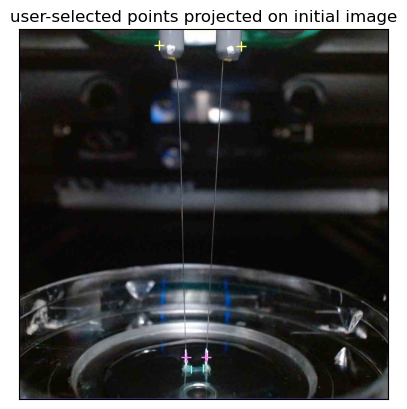

In [37]:
# MANUALLY SELECT INITIAL DATA POINT POSITIONS (necessary for either Automated or Manual Analysis)

# select points:
%matplotlib tk
plt.figure(figsize = (11,7)) # NOTE: ideal values may vary depending on your screen size
plt.imshow(~imgs_cam[0][:,:,1], cmap='gray') # display inverted single-channel image
rawData_cam[0,:,:] = np.around(plt.ginput(6, timeout=0)) # user selects 6 points
plt.close()

# display selected points:
%matplotlib inline
plt.imshow(imgs_cam[0])
plt.scatter(rawData_cam[0,0:2,0], rawData_cam[0,0:2,1],\
            s=50, c=[[1,1,0.5]], marker='+', linewidths=1) # cantilever top
plt.scatter(rawData_cam[0,2:4,0], rawData_cam[0,2:4,1],\
            s=50, c=[[1,0.5,1]], marker='+', linewidths=1) # cantilever bottom
plt.scatter(rawData_cam[0,4:6,0], rawData_cam[0,4:6,1],\
            s=30, c=[[0.5,1,1]], marker='|', linewidths=1) # tissue
plt.title('user-selected points projected on initial image')
plt.xticks([])
plt.yticks([])

In [38]:
# AUTOMATED CANTILEVER ANALYSIS

"""
iterate through rest of images and track structures by shifting measurement point positions from
one image to the next by comparing SSIMs of ROIs taken around those points (i.e. shift the point
in the current image until the SSIM between the ROI around that point position in the current image
and the ROI around the initial point position in the first image is maximized):
"""

for i_img in range(1,len(imgs_cam)):
    for i_pnt in range(rawData_cam.shape[1]):
        # set the direction of shifting ROI based on point being analyzed:
        if i_pnt%2 == 0:
            dir_shift = -1 # points at 0, 2, and 4 shift left
        else:
            dir_shift = 1 # points at 1, 3, and 5 shift right
        # re-isolate initial ROI for this data point:
        roi_init = imgs_cam[0][rawData_cam[0,i_pnt,1].astype(int)-rad_roi:\
                                     rawData_cam[0,i_pnt,1].astype(int)+rad_roi,\
                                     rawData_cam[0,i_pnt,0].astype(int)-rad_roi:\
                                     rawData_cam[0,i_pnt,0].astype(int)+rad_roi, :]
        # isolate 3D ROI around previous data point in current image:
        roi_cur = imgs_cam[i_img][rawData_cam[i_img-1,i_pnt,1].astype(int)-rad_roi:\
                                  rawData_cam[i_img-1,i_pnt,1].astype(int)+rad_roi,\
                                  rawData_cam[i_img-1,i_pnt,0].astype(int)-rad_roi:\
                                  rawData_cam[i_img-1,i_pnt,0].astype(int)+rad_roi, :]
        # calculate SSIM between initial and current ROIs:
        ssim_cur = ssim(roi_cur, roi_init, channel_axis=2)
        ssim_max = ssim_cur # start by assuming that this SSIM is the maximum (closest to 1)
        rawData_cam[i_img,i_pnt,:] = rawData_cam[i_img-1,i_pnt,:] # use previous position as initial current position
        # shift ROI horizontally to find new position of max SSIM:
        for len_shift in range(range_roiShift):
            # isolate new shifted 3D ROI in current image:
            roi_cur = imgs_cam[i_img][rawData_cam[i_img-1,i_pnt,1].astype(int)-rad_roi:\
                                      rawData_cam[i_img-1,i_pnt,1].astype(int)+rad_roi,\
                                      rawData_cam[i_img-1,i_pnt,0].astype(int)-rad_roi + dir_shift*len_shift:\
                                      rawData_cam[i_img-1,i_pnt,0].astype(int)+rad_roi + dir_shift*len_shift, :]
            # calculate (and compare) SSIM between initial and current ROIs: 
            ssim_cur = ssim(roi_cur, roi_init, channel_axis=2)
            if ssim_cur > ssim_max * 1.5:
                ssim_max = ssim_cur
                rawData_cam[i_img,i_pnt,0] = rawData_cam[i_img-1,i_pnt,0] + dir_shift*len_shift # update horizontal position
        # shift (tissue) ROI vertically to refine new position of max SSIM:
        if i_pnt == 4 or i_pnt == 5:
            for len_shift in np.linspace(-5, 5, 11).astype(int):
                # isolate new shifted 3D ROI in current image:
                roi_cur = imgs_cam[i_img][rawData_cam[i_img-1,i_pnt,1].astype(int)-rad_roi + len_shift:\
                                          rawData_cam[i_img-1,i_pnt,1].astype(int)+rad_roi + len_shift,\
                                          rawData_cam[i_img,i_pnt,0].astype(int)-rad_roi:\
                                          rawData_cam[i_img,i_pnt,0].astype(int)+rad_roi, :]
                # calculate (and compare) SSIM between initial and current ROIs: 
                ssim_cur = ssim(roi_cur, roi_init, channel_axis=2)
                if ssim_cur > ssim_max:
                    ssim_max = ssim_cur
                    rawData_cam[i_img,i_pnt,1] = rawData_cam[i_img-1,i_pnt,1] + len_shift # update vertical position
    # display progress (every 3 images):
    if i_img%3 == 0:
        print(f'Images completed:  {i_img} of {len(imgs_cam)-1}')

print('Automated analysis complete.')

Images completed:  3 of 29
Images completed:  6 of 29
Images completed:  9 of 29
Images completed:  12 of 29
Images completed:  15 of 29
Images completed:  18 of 29
Images completed:  21 of 29
Images completed:  24 of 29
Images completed:  27 of 29
Automated analysis complete.


[]

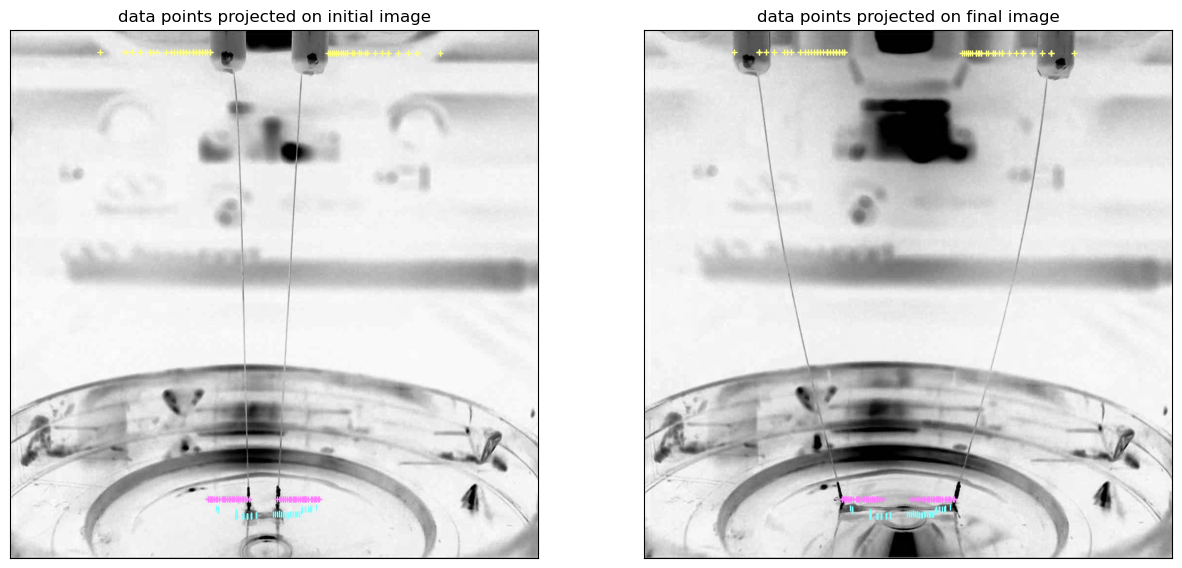

In [39]:
# DISPLAY RAW RESULTS OF CANTILEVER ANALYSIS

# display first and last images, both with all scatter points:
figure, subFigs = plt.subplots(1, 2, figsize=(15, 10))
# first image:
subFigs[0].imshow(~imgs_cam[0][:,:,1], cmap='gray')
for i_img in range(len(imgs_cam)):    
    subFigs[0].scatter(rawData_cam[i_img,0:2,0], rawData_cam[i_img,0:2,1],\
                s=25, c=[[1,1,0.5]], marker='+', linewidths=1) # cantilever top
    subFigs[0].scatter(rawData_cam[i_img,2:4,0], rawData_cam[i_img,2:4,1],\
                s=25, c=[[1,0.5,1]], marker='+', linewidths=1) # cantilever bottom
    subFigs[0].scatter(rawData_cam[i_img,4:6,0], rawData_cam[i_img,4:6,1],\
                s=15, c=[[0.5,1,1]], marker='|', linewidths=1) # tissue
subFigs[0].set_title('data points projected on initial image')
subFigs[0].set_xticks([])
subFigs[0].set_yticks([])
# last image:
subFigs[1].imshow(~imgs_cam[-1][:,:,1], cmap='gray')
for i_img in range(len(imgs_cam)):    
    subFigs[1].scatter(rawData_cam[i_img,0:2,0], rawData_cam[i_img,0:2,1],\
                s=25, c=[[1,1,0.5]], marker='+', linewidths=1) # cantilever top
    subFigs[1].scatter(rawData_cam[i_img,2:4,0], rawData_cam[i_img,2:4,1],\
                s=25, c=[[1,0.5,1]], marker='+', linewidths=1) # cantilever bottom
    subFigs[1].scatter(rawData_cam[i_img,4:6,0], rawData_cam[i_img,4:6,1],\
                s=15, c=[[0.5,1,1]], marker='|', linewidths=1) # tissue
subFigs[1].set_title('data points projected on final image')
subFigs[1].set_xticks([])
subFigs[1].set_yticks([])

# PROCESS DATA

In [40]:
# CLEAN AND RESCALE CANTILEVER IMAGING DATA

# rescale data point x positions:
cleanData_cam = rawData_cam
for i_adj in i_camImgAdjustment:
    for i_img in range(i_adj,len(imgs_cam)):
        for i_pnt in range(rawData_cam.shape[1]):
            cleanData_cam[i_img,i_pnt,0] *= cleanData_cam[i_adj-1,i_pnt,0] / cleanData_cam[i_adj,i_pnt,0]
# remove 'redundant' images:
cleanData_cam = np.delete(cleanData_cam, i_camImgAdjustment, 0)

# convert data from pixels to mm:
cleanData_cam *= res_cam

print('Raw data cleaned of discontinuities.')

Raw data cleaned of discontinuities.


"scale_deflCorrection" (SAVE THIS FOR SCALING EXPERIMENTAL RUNS):  0.261


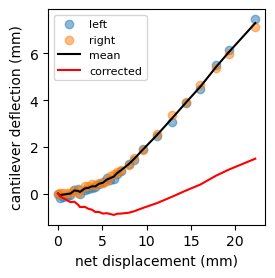

In [16]:
# [ !!! use this block only for blank test runs !!! ]
# CALCULATE DEFLECTION CORRECTION SCALE

# calculate cantilever deflection and tissue stretch:
disp_levers = np.zeros(len(cleanData_cam[:,0,0]))
defl_leverL = np.zeros(len(cleanData_cam[:,0,0]))
defl_leverR = np.zeros(len(cleanData_cam[:,0,0]))
stretch_tissue = np.zeros(len(cleanData_cam[:,0,0]))
for i_img in range(len(cleanData_cam[:,0,0])):
    disp_levers[i_img] = abs(cleanData_cam[i_img,0,0]-cleanData_cam[i_img,1,0])\
    - abs(cleanData_cam[0,0,0]-cleanData_cam[0,1,0])
    defl_leverL[i_img] = abs(cleanData_cam[i_img,0,0]-cleanData_cam[i_img,2,0])\
    - abs(cleanData_cam[0,0,0]-cleanData_cam[0,2,0])
    defl_leverR[i_img] = abs(cleanData_cam[i_img,1,0]-cleanData_cam[i_img,3,0])\
    - abs(cleanData_cam[0,1,0]-cleanData_cam[0,3,0])
    stretch_tissue[i_img] = abs(cleanData_cam[i_img,4,0]-cleanData_cam[i_img,5,0])\
    / abs(cleanData_cam[0,4,0]-cleanData_cam[0,5,0])
defl_mean = (defl_leverL + defl_leverR) / 2

# scale data so mean slope of blank run ~ 0:
slope, _, _, _ = np.linalg.lstsq(disp_levers[:,np.newaxis], defl_mean, rcond=None)
scale_deflCorrection = round(slope[0], 4)
defl_corrected = defl_mean - disp_levers * scale_deflCorrection

# display deflection-displacement data:
plt.figure(figsize = (2.8,2.8))
plt.scatter(disp_levers, defl_leverL, alpha=0.5)
plt.scatter(disp_levers, defl_leverR, alpha=0.5)
plt.plot(disp_levers, defl_mean, 'k')
plt.plot(disp_levers, defl_corrected, 'r')
plt.xlabel('net displacement (mm)')
plt.ylabel('cantilever deflection (mm)')
plt.legend(['left', 'right', 'mean', 'corrected'], fontsize=8)

print(f'"scale_deflCorrection" (SAVE THIS FOR SCALING EXPERIMENTAL RUNS):  {scale_deflCorrection}')

index of starting image:  4


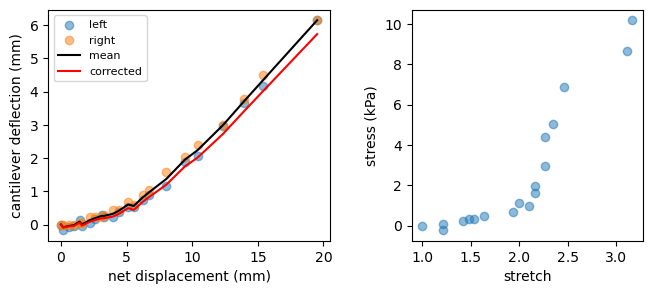

In [41]:
# CALCULATE STRESS AND STRETCH

# calculate cantilever deflection and tissue stretch:
disp_levers = np.zeros(len(cleanData_cam[:,0,0]))
defl_leverL = np.zeros(len(cleanData_cam[:,0,0]))
defl_leverR = np.zeros(len(cleanData_cam[:,0,0]))
stretch_tissue = np.zeros(len(cleanData_cam[:,0,0]))
for i_img in range(len(cleanData_cam[:,0,0])):
    disp_levers[i_img] = abs(cleanData_cam[i_img,0,0]-cleanData_cam[i_img,1,0])\
        - abs(cleanData_cam[0,0,0]-cleanData_cam[0,1,0])
    defl_leverL[i_img] = abs(cleanData_cam[i_img,0,0]-cleanData_cam[i_img,2,0])\
        - abs(cleanData_cam[0,0,0]-cleanData_cam[0,2,0])
    defl_leverR[i_img] = abs(cleanData_cam[i_img,1,0]-cleanData_cam[i_img,3,0])\
        - abs(cleanData_cam[0,1,0]-cleanData_cam[0,3,0])
    stretch_tissue[i_img] = abs(cleanData_cam[i_img,4,0]-cleanData_cam[i_img,5,0])\
        / abs(cleanData_cam[0,4,0]-cleanData_cam[0,5,0])
defl_mean = (defl_leverL + defl_leverR) / 2

# scale data to correct for webcam distortion:
defl_corrected = defl_mean - disp_levers * scale_deflCorrection
        
# display deflection-displacement data:
figure, subFigs = plt.subplots(1, 2, figsize=(8, 3))
subFigs[0].scatter(disp_levers, defl_leverL, alpha=0.5)
subFigs[0].scatter(disp_levers, defl_leverR, alpha=0.5)
subFigs[0].plot(disp_levers, defl_mean, 'k')
subFigs[0].plot(disp_levers, defl_corrected, 'r')
subFigs[0].set_xlabel('net displacement (mm)')
subFigs[0].set_ylabel('cantilever deflection (mm)')
#subFigs[0].set_aspect(abs((np.max(disp_levers)-np.min(disp_levers))/(np.max(defl_leverL)-np.min(defl_leverL))))
subFigs[0].legend(['left', 'right', 'mean', 'corrected'], fontsize=8)

# set increasing displacement constraint, then set new initial displacement to 0:
range_dispConstraint = 5;
for i_img in range(len(defl_corrected)):
    fit = linreg(np.linspace(0,1,range_dispConstraint), defl_corrected[i_img:i_img+range_dispConstraint])
    if fit.slope > 0 and fit.pvalue < 0.1: # slope is confidently (95%) positive in this window of measurements
        # set measurement i_img as the first measurement (i.e. when deflection = 0):
        defl_corrected = defl_corrected[i_img:-1] - defl_corrected[i_img]
        stretch_tissue = stretch_tissue[i_img:-1] / stretch_tissue[i_img]
        print(f'index of starting image:  {i_img}')
        break
    if i_img == len(defl_corrected)-range_dispConstraint:
        print('stress is insignificant')
# i_firstImg = 0
# i_imgAtDip = 0
# dips = 0
# for i_img in range(len(defl_corrected)-1):
#     if defl_corrected[i_img] > defl_corrected[i_img+1]:
#         # set measurement i_img+1 as the first measurement (i.e. when deflection = 0):
#         dips += 1
#         if dips > 1:
#             i_firstImg = i_imgAtDip
#             i_imgAtDip = i_img + 1
#             dips -= 1
#         else:
#             i_imgAtDip = i_img + 1
# defl_corrected = defl_corrected[i_firstImg:-1] - defl_corrected[i_firstImg]
# stretch_tissue = stretch_tissue[i_firstImg:-1] / stretch_tissue[i_firstImg]
# print(f'index of starting image:  {i_firstImg}  of  {len(defl_mean)}')

# convert (mean) deflection to stress using cantilever bending stiffness and tissue geometry:
stress_tissue = defl_corrected * stiffness_lever / area_tissue

# display calculated mechanics data:
subFigs[1].scatter(stretch_tissue, stress_tissue, alpha=0.5)
subFigs[1].set_xlabel('stretch')
subFigs[1].set_ylabel('stress (kPa)')
subFigs[1].set_aspect(abs((np.max(stretch_tissue)-np.min(stretch_tissue))/(np.max(stress_tissue)-np.min(stress_tissue))))

In [46]:
# EXPORT STRESS-STRETCH DATA

df_stressStretch = pd.DataFrame({'stretch': stretch_tissue,'stress(kPa)': stress_tissue})
df_stressStretch.to_csv('fullData_stress-stretch_DMSOexp7')

# ANALYZE DATA

In [32]:
# [ !!! use this block only if importing data !!! ]
# IMPORT EXISTING STRESS-STRETCH DATA FILE

df_stressStretch_imported = pd.read_csv(r'C:\Users\John Durel\Documents\Python Scripts\data_stress-stretch_DMSO-s1')
stretch_tissue = df_stressStretch_imported.loc[:,"stretch"].to_numpy()
stress_tissue = df_stressStretch_imported.loc[:,"stress(kPa)"].to_numpy()

E_toe =  1.4  kPa
E_lin =  41.7  kPa
λ* =  2.1


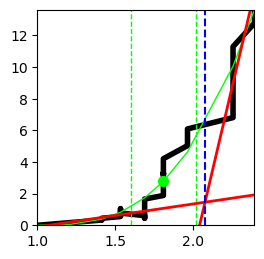

In [44]:
# CALCULATE MODULI AND TRANSITION STRETCH

"""
here we use a one-term power series to fit the mechanical testing data, use the point of max curvature of this
fit to differentiate between "toe" and "linear" regions of the curve, and fit a linear regression to each of
these regions; the slope of these linear fits give us the elastic muduli and their x-axis intersect gives us
the transition stretch.
"""

# smooth (power fit) and normalize data:
def func_power1(x, a, b):
    return a * (x-1)**b
fit_smoothing = curve_fit(func_power1, stretch_tissue, stress_tissue)[0]
data_smooth = np.stack((stretch_tissue, func_power1(stretch_tissue, *fit_smoothing)), axis=1)
data_zeroed = np.stack((data_smooth[:,0]-data_smooth[1,0], data_smooth[:,1]-data_smooth[1,1]), axis=1)
data_normalized = np.stack((data_zeroed[:,0]/np.max(data_zeroed[:,0]), data_zeroed[:,1]/np.max(data_zeroed[:,1])), axis=1)

# find index of elbow (defined as the point of max distance to diagonal):
dist_toDiag = data_normalized[:,0] - data_normalized[:,1];
i_elbow = np.argmax(dist_toDiag);

# define -/+15% x-axis bounds around elbow:
range_x = (np.max(data_smooth[:,0]) - np.min(data_smooth[:,0])) * 0.15;
bounds_x = [data_smooth[i_elbow,0] - range_x, data_smooth[i_elbow,0] + range_x];

# use these bounds to split data into 'toe' and 'linear' subsets:
stretch_toe = stretch_tissue[stretch_tissue < bounds_x[0]]
stress_toe = stress_tissue[stretch_tissue < bounds_x[0]]
stretch_lin = stretch_tissue[stretch_tissue > bounds_x[1]]
stress_lin = stress_tissue[stretch_tissue > bounds_x[1]]

# perform linear fits for the 'toe' and 'linear' subsets:
fit_toe = linreg(stretch_toe, stress_toe);
fit_lin = linreg(stretch_lin, stress_lin);

# calculate toe and linear region moduli and transition strain:
E_toe = fit_toe.slope;
E_lin = fit_lin.slope;
stretch_trans = (fit_toe.intercept-fit_lin.intercept) / (fit_lin.slope-fit_toe.slope); # horizontal value (stretch) of intersect
measures_fit = np.array([E_toe, E_lin, stretch_trans])

# plot data:
plt.figure(figsize = (2.8,2.8))
plt.plot(stretch_tissue, stress_tissue, 'k', linewidth=4)
plt.plot(data_smooth[:,0], data_smooth[:,1], color=(0,1,0), linewidth=1)
# visualize elbow zone:
plt.scatter(data_smooth[i_elbow,0], data_smooth[i_elbow,1], s=50, color=(0,1,0), zorder=2)
plt.plot([bounds_x[0], bounds_x[0]], [0,np.max(data_smooth[:,1])], color=(0,1,0), linestyle='--', linewidth=1)
plt.plot([bounds_x[1], bounds_x[1]], [0,np.max(data_smooth[:,1])], color=(0,1,0), linestyle='--', linewidth=1)
# visualize 'toe' and 'linear' region linear fits:
plt.plot(stretch_tissue, fit_toe.intercept + fit_toe.slope * stretch_tissue, color=(1,0,0), linewidth=2)
plt.plot(stretch_tissue, fit_lin.intercept + fit_lin.slope * stretch_tissue, color=(1,0,0), linewidth=2)
plt.plot([stretch_trans, stretch_trans], [0, max(data_smooth[:,1])], color=(0,0,1), linestyle='--')
# make look nicer:
plt.ylim([0,np.max(data_smooth[:,1])])
plt.xlim([1,np.max(data_smooth[:,0])])

# display calculated values:
print(f'E_toe =  {round(E_toe,1)}  kPa');
print(f'E_lin =  {round(E_lin,1)}  kPa');
print(f'λ* =  {round(stretch_trans,1)}');


In [266]:
# EXPORT MECHANICAL MEAUREMENTS

df_fitMeasures = pd.DataFrame({'E_toe (kPa)': [measures_fit[0]],'E_lin (kPa)': [measures_fit[1]], 'λ*': [measures_fit[2]]})
df_fitMeasures.to_csv('data_fitMeasures_CDexp2_meanBlank_halfData')